In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))

# Purpose
- Purpose of this notebook is to train an LSTM model

In [90]:
import warnings
import gc
from IPython.display import display
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold
import optuna

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.backend import clear_session

from src.pipeline_transformers import ColumnDropperTransformer

# Load Data

In [124]:
nrows = None
X_train = pd.read_csv("data/transformed/X_train.csv", nrows=nrows)
X_val = pd.read_csv("data/transformed/X_val.csv", nrows=nrows)
X_test = pd.read_csv("data/transformed/X_test.csv", nrows=nrows)

y_train = pd.read_csv("data/transformed/y_train.csv", nrows=nrows)
y_val = pd.read_csv("data/transformed/y_val.csv", nrows=nrows)
y_test = pd.read_csv("data/transformed/y_test.csv", nrows=nrows)

display(X_val.tail())
display(y_val.tail())

,user_id,timestamp,x,y,z
199293,25,8688572339000,10.53,14.90,14.90
199294,25,8688622327000,3.17,15.70,15.70
199295,25,8688672346000,-1.04,15.79,15.79
199296,25,8688722333000,6.13,10.23,10.23
199297,25,8688772321000,0.08,9.23,9.23


,activity
199293,Jogging
199294,Jogging
199295,Jogging
199296,Jogging
199297,Jogging


# Define Parameters

In [125]:
timesteps = 240
n_features = 3
n_classes = len(y_train["activity"].unique().tolist())

# Preprocess

In [126]:
# normalize the data and convert back to dataframe
columns = X_train.columns

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=columns)

# label encode the target variable
encoder = LabelEncoder()
y_train = pd.DataFrame(encoder.fit_transform(y_train), columns=["activity"])
y_val = pd.DataFrame(encoder.transform(y_val), columns=["activity"])
y_test = pd.DataFrame(encoder.transform(y_test), columns=["activity"])

# save the scaler and encoder using joblib
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(encoder, "models/encoder.pkl")

['models/encoder.pkl']

In [127]:
encoder.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [129]:
data = X_train.merge(y_train, left_index=True, right_index=True)
data.head()

,user_id,timestamp,x,y,z,activity
0,0.0,0.023839,0.513664,0.766961,0.766961,5
1,0.0,0.023840,0.669534,0.682219,0.682219,5
2,0.0,0.023840,0.519737,0.636570,0.636570,5
3,0.0,0.023840,0.442814,0.620933,0.620933,5
4,0.0,0.023840,0.380061,0.602774,0.602774,5


In [132]:
y_test["activity"].value_counts()

5    91540
1    85115
4    41115
0    28372
2    10985
3     9495
Name: activity, dtype: int64

In [122]:
data = X_train.merge(y_train, left_index=True, right_index=True)

# normalize X_train, y_train, z
data[['x', 'y', 'z']] = MinMaxScaler().fit_transform(data[['x', 'y', 'z']])

# order by_train user_id and timestamp
data = data.sort_values(['user_id', 'timestamp'])
data = data.groupby(['user_id', 'activity']).tail(240)
y_train = data['activity']

In [123]:
y_train

17620     5
17621     5
17622     5
17623     5
17624     5
         ..
632279    5
632280    5
632281    5
632282    5
632283    5
Name: activity, Length: 26400, dtype: int64

In [100]:
def preprocess_data(X: pd.DataFrame, y: pd.DataFrame, n_timesteps: int = 80):
    """
    Preprocess data for LSTM model.
    """


    # merge X and y on index
    data = X.merge(y, left_index=True, right_index=True)

    # normalize x, y, z
    data[['x', 'y', 'z']] = MinMaxScaler().fit_transform(data[['x', 'y', 'z']])
    
    # order by user_id and timestamp
    data = data.sort_values(['user_id', 'timestamp'])
    data = data.groupby(['user_id', 'activity']).tail(n_timesteps)
    y = data['activity']
    # replace timestamp with range of timesteps
    data['timestamp'] = data.groupby(['user_id', 'activity']).cumcount()

    # reshape data
    X = data[['x', 'y', 'z']].values.reshape(-1, n_timesteps, 3)

    y = data.groupby(['user_id', 'activity']).first().reset_index()[['activity']]

    return X, y

In [109]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [110]:
# merge X_train and y_train
df_train = X_train.merge(y_train, left_index=True, right_index=True)

# merge X_val and y_val
df_val = X_val.merge(y_val, left_index=True, right_index=True)

In [111]:
TIME_STEPS = 240
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x', 'y', 'z']],
    df_train.activity,
    TIME_STEPS,
    STEP
)

X_val, y_val = create_dataset(
    df_val[['x', 'y', 'z']],
    df_val.activity,
    TIME_STEPS,
    STEP
)

In [112]:
X_train.shape

(15802, 240, 3)

In [101]:
X_train, y_train = preprocess_data(X_train, y_train, timesteps)
X_val, y_val = preprocess_data(X_val, y_val, timesteps)
X_test, y_test = preprocess_data(X_test, y_test, timesteps)

In [104]:
X_train.shape

(110, 240, 3)

# Hyper-parameter Tuning

In [9]:
# increase epochs
# increase patience
# add extra layer to model
# Use Shap for feature importance
# https://stackoverflow.com/questions/70655055/trying-to-callibrate-keras-model

In [56]:
def objective(trial: optuna.trial.Trial) -> float:
    '''Takes in hyperparameters as input, and trains a model that computes accuracy on the validation set.'''
    clear_session()

    # define early stopping
    early_stop = EarlyStopping(monitor='val_loss',patience=10)

    # define model architecture
    model = Sequential()

    model.add(
        keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=trial.suggest_int("units", 128, 512, log=True),
            input_shape=(timesteps, n_features))))

    model.add(keras.layers.Dropout(rate=trial.suggest_uniform("dropout", 0.0, 0.5)))

    model.add(keras.layers.Dense(units=trial.suggest_int("units", 128, 512, log=True), activation='relu'))

    model.add(keras.layers.Dense(n_classes, activation='softmax'))

    # compile model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer='adam',
        metrics=["acc"])
        
    # fit model
    model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=trial.suggest_int("batch_size", 32, 128, log=True),
        validation_data=(X_val, y_val),
        shuffle=True,
        callbacks=[early_stop],
        verbose=False,
    )

    # compute validation error
    score = model.score(X_val, y_val, verbose=0)
    
    return score

In [12]:
warnings.filterwarnings('ignore')

# optuna study
study = optuna.create_study(direction="maximize", study_name="lstm")
study.optimize(objective, n_trials=5)

[I 2023-04-03 13:15:16,310] A new study created in memory with name: lstm


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-03 13:15:16.473698: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
[I 2023-04-03 13:46:48,349] Trial 0 finished with value: 0.25925925374031067 and parameters: {'units': 33, 'dropout': 0.38690914186595604}. Best is trial 0 with value: 0.25925925374031067.


[I 2023-04-03 14:52:29,984] Trial 1 finished with value: 0.1111111119389534 and parameters: {'units': 38, 'dropout': 0.3139180835132931}. Best is trial 0 with value: 0.25925925374031067.


[I 2023-04-03 15:27:39,666] Trial 2 finished with value: 0.14814814925193787 and parameters: {'units': 37, 'dropout': 0.08936777068475527}. Best is trial 0 with value: 0.25925925374031067.


[I 2023-04-03 16:06:18,138] Trial 3 finished with value: 0.2222222238779068 and parameters: {'units': 113, 'dropout': 0.06681612628015637}. Best is trial 0 with value: 0.25925925374031067.


[I 2023-04-03 16:49:20,252] Trial 4 finished with value: 0.14814814925193787 and parameters: {'units': 181, 'dropout': 0.48579791492969854}. Best is trial 0 with value: 0.25925925374031067.


In [13]:
# print best parameters
best_params = study.best_trial.params
print(f'{best_params=}')

best_params={'units': 33, 'dropout': 0.38690914186595604}


# Fit model with best parameters

In [14]:
units = best_params['units']
dropout = best_params['dropout']

In [65]:
clear_session()
# define early stopping
early_stop = EarlyStopping(monitor='val_loss',patience=10)

# define model architecture
best_model = Sequential()

best_model.add(
    Bidirectional(
        LSTM(
            units=units,
            input_shape=(timesteps, n_features))))

best_model.add(Dropout(rate=dropout))

best_model.add(Dense(units=units, activation='relu'))

best_model.add(Dense(n_classes, activation='softmax'))

# compile model
best_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer='adam',
    metrics=["acc"])
    
# fit model
best_model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[early_stop],
    verbose=False,
)

<Axes: >

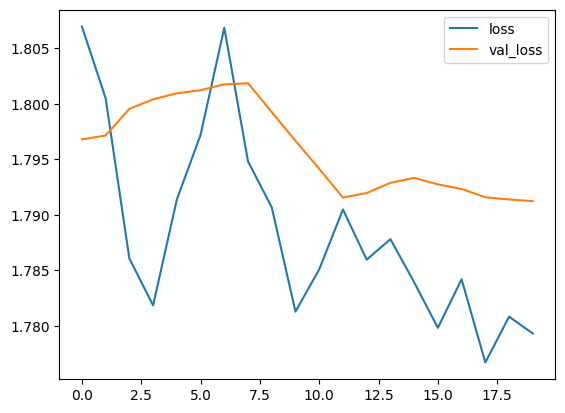

In [66]:
losses = pd.DataFrame(best_model.history.history)
losses[['loss', 'val_loss']].plot()

<Axes: >

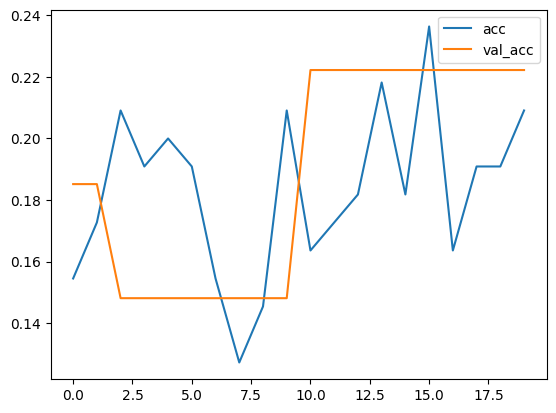

In [71]:
accuracy = pd.DataFrame(best_model.history.history)
accuracy[['acc', 'val_acc']].plot()

In [72]:
# Evaluate the model accuracy on the test set.
score = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.7757368087768555 / Test accuracy: 0.190476194024086


# Save Predictions & model

In [20]:
# save the model using joblib
joblib.dump(best_model, "models/lstm_model.pkl")

INFO:tensorflow:Assets written to: ram://b9b7c109-8d6e-49bf-a791-68ea83496c2e/assets


['models/lstm_model.pkl']

In [74]:
# save predictions
y_pred = best_model.predict(X_test)

#y_pred = pd.DataFrame(y_pred, columns=["activity"])
#y_pred.to_csv("predictions/raw_predictions_lstm.csv", index=False)

2/2 [==============================] - 2s 884ms/step


In [75]:
y_pred

array([[0.17166854, 0.16241647, 0.1367863 , 0.14395718, 0.18497398,
        0.20019753],
       [0.17085749, 0.16446361, 0.13498338, 0.13614614, 0.18503724,
        0.20851217],
       [0.17213994, 0.16309305, 0.13346894, 0.13700986, 0.18638301,
        0.20790516],
       [0.16849354, 0.16436991, 0.13815409, 0.13896449, 0.18556233,
        0.20445558],
       [0.17394632, 0.16574809, 0.13267261, 0.14250176, 0.18344083,
        0.20169047],
       [0.1716788 , 0.16461205, 0.13269375, 0.13704872, 0.18605332,
        0.20791334],
       [0.17147815, 0.1624037 , 0.13434525, 0.13690382, 0.18687722,
        0.20799187],
       [0.171303  , 0.16163385, 0.13542175, 0.13875632, 0.1879741 ,
        0.20491098],
       [0.17091838, 0.16289803, 0.13366498, 0.13416375, 0.18770619,
        0.21064869],
       [0.16647765, 0.16601789, 0.14140494, 0.14377967, 0.18293628,
        0.19938353],
       [0.17119424, 0.1651038 , 0.13246064, 0.13476533, 0.18594131,
        0.21053465],
       [0.1709609 , 0

In [76]:
# select the index with the maximum probability for each row
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [23]:
y_test

,activity
0,0
1,1
2,2
3,3
4,4
5,5
6,0
7,1
8,4
9,5


In [24]:
calibrated_model = CalibratedClassifierCV(best_model, cv='prefit', method='isotonic', n_jobs=10)
calibrated_model.fit(X_val, y_val)

1/1 [==============================] - 2s 2s/step


CalibratedClassifierCV(cv='prefit',
                       estimator=<__main__.MyKerasClassifier object at 0x2c9199040>,
                       method='isotonic', n_jobs=10)

In [25]:
calibrated_preds = calibrated_model.predict_proba(X_test)
calibrated_preds

2/2 [==============================] - 4s 2s/step


array([[0.13802302, 0.2366109 , 0.16562763, 0.20703453, 0.09742802,
        0.1552759 ],
       [0.21164021, 0.        , 0.        , 0.12698413, 0.42328043,
        0.23809523],
       [0.27916251, 0.        , 0.        , 0.16749751, 0.23928216,
        0.31405782],
       [0.11215834, 0.11875589, 0.        , 0.        , 0.09613572,
        0.67295004],
       [0.14173256, 0.19813341, 0.17007907, 0.21259884, 0.11800698,
        0.15944913],
       [0.17051154, 0.18054163, 0.17051154, 0.10230692, 0.12036108,
        0.2557673 ],
       [0.19546686, 0.20696491, 0.095666  , 0.11728012, 0.1647219 ,
        0.21990021],
       [0.16614026, 0.17591321, 0.19177653, 0.09968415, 0.11727547,
        0.24921038],
       [0.17989418, 0.19047619, 0.        , 0.        , 0.35978836,
        0.26984126],
       [0.18215912, 0.19287437, 0.18215912, 0.10929547, 0.12858291,
        0.20492901],
       [0.18730379, 0.19832166, 0.18730379, 0.        , 0.1461151 ,
        0.28095567],
       [0.17051154, 0